### Notebook based on:
https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('max_colwidth', -1)

# Read data

In [2]:
df = pd.read_csv("data/movieReviews_trainLabel.tsv", sep="\t", index_col="id")
print(df.shape)
df.head(1)

(25000, 2)


,sentiment,review
id,,
5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally starts is only on for 20 minutes or so excluding the Smooth Criminal sequence and Joe Pesci is convincing as a psychopathic all powerful drug lord. Why he wants MJ dead so bad is beyond me. Because MJ overheard his plans? Nah, Joe Pesci's character ranted that he wanted people to know it is he who is supplying drugs etc so i dunno, maybe he just hates MJ's music.<br /><br />Lots of cool things in this like MJ turning into a car and a robot and the whole Speed Demon sequence. Also, the director must have had the patience of a saint when it came to filming the kiddy Bad sequence as usually directors hate working with one kid let alone a whole bunch of them performing a complex dance scene.<br /><br />Bottom line, this movie is for people who like MJ on one level or another (which i think is most people). If not, then stay away. It does try and give off a wholesome message and ironically MJ's bestest buddy in this movie is a girl! Michael Jackson is truly one of the most talented people ever to grace this planet but is he guilty? Well, with all the attention i've gave this subject....hmmm well i don't know because people can be different behind closed doors, i know this for a fact. He is either an extremely nice but stupid guy or one of the most sickest liars. I hope he is not the latter."


# EDA
### Target

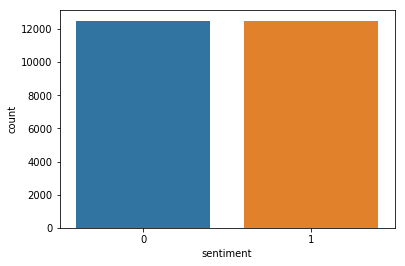

In [3]:
sns.countplot(df['sentiment']);

### Text

In [4]:
positive = df[df['sentiment']==1]['review']
negative = df[df['sentiment']==0]['review']

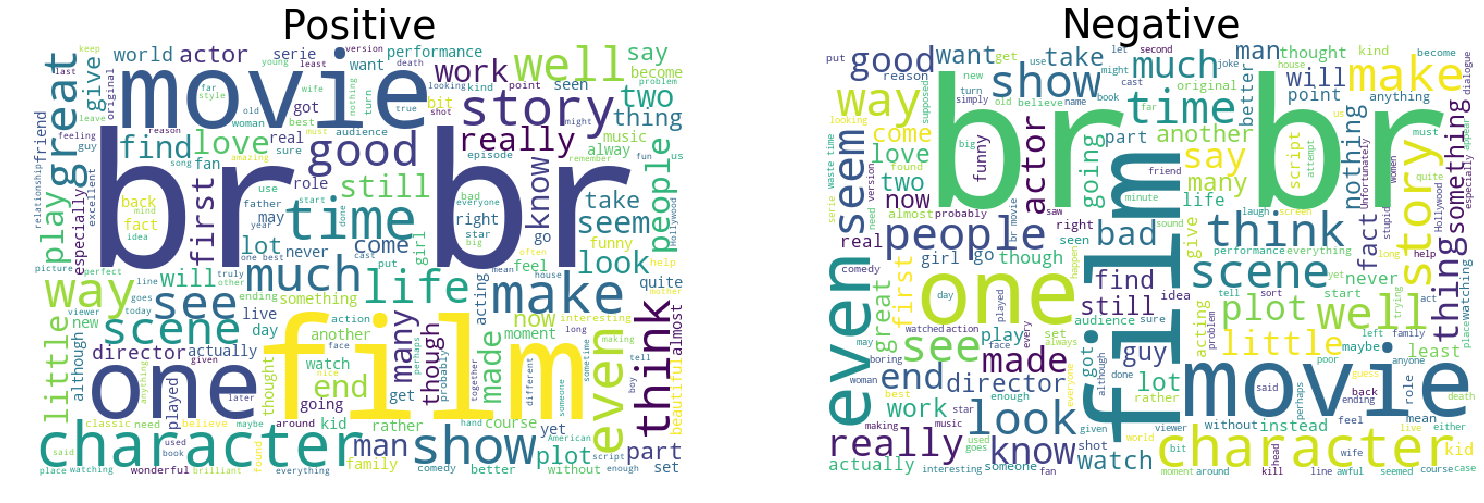

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

In [6]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df['review'])
##test_vectors  = count_vectorizer.transform(test["text"])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


# TFIDF Features
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [7]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(df['review'])
##test_tfidf  = tfidf.transform(test["text"])

# Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score

In [9]:
models = [
    #('Logistic Regression', LogisticRegression(C=1.0, max_iter=1000, n_jobs=-1)),
     ('Naive Bayes',         MultinomialNB()),
    #('Decision Tree',       DecisionTreeClassifier()),
    #('Extra Trees',         ExtraTreesClassifier(n_jobs=-1)),
    #('Random Forest',       RandomForestClassifier(n_jobs=-1)),
    #('Gradient Boosting',   GradientBoostingClassifier()),
    #('XGBoost',             XGBClassifier())
    #xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.1)   
]


outcome = []
Modelnames = []

for name, model in models:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv_r = cross_val_score(model, train_vectors, df["sentiment"], cv=skf, scoring='accuracy')
    outcome.append(cv_r)
    Modelnames.append(name)
    print("%s: %.2f%% (%.2f%%)" % (name, cv_r.mean()*100, cv_r.std()*100))

Naive Bayes: 84.87% (0.56%)


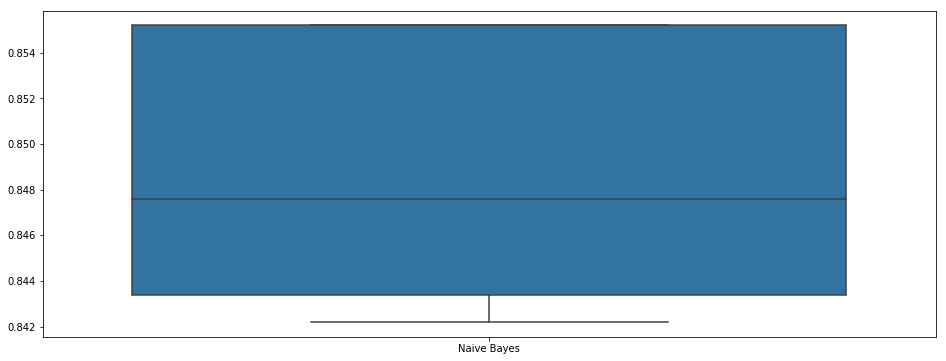

In [11]:
results ={'Names': Modelnames,'Results': outcome}
plt.figure(figsize=(16,6))
sns.boxplot(x='Names',y='Results',data=results);

In [12]:
models = [
    #('Logistic Regression', LogisticRegression(C=1.0, max_iter=1000, n_jobs=-1)),
     ('Naive Bayes',         MultinomialNB()),
    #('Decision Tree',       DecisionTreeClassifier()),
    #('Extra Trees',         ExtraTreesClassifier(n_jobs=-1)),
    #('Random Forest',       RandomForestClassifier(n_jobs=-1)),
    #('Gradient Boosting',   GradientBoostingClassifier()),
    #('XGBoost',             XGBClassifier())
    #xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.1)   
]


outcome = []
Modelnames = []

for name, model in models:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv_r = cross_val_score(model, train_tfidf, df["sentiment"], cv=skf, scoring='accuracy')
    outcome.append(cv_r)
    Modelnames.append(name)
    print("%s: %.2f%% (%.2f%%)" % (name, cv_r.mean()*100, cv_r.std()*100))

Naive Bayes: 88.76% (0.25%)


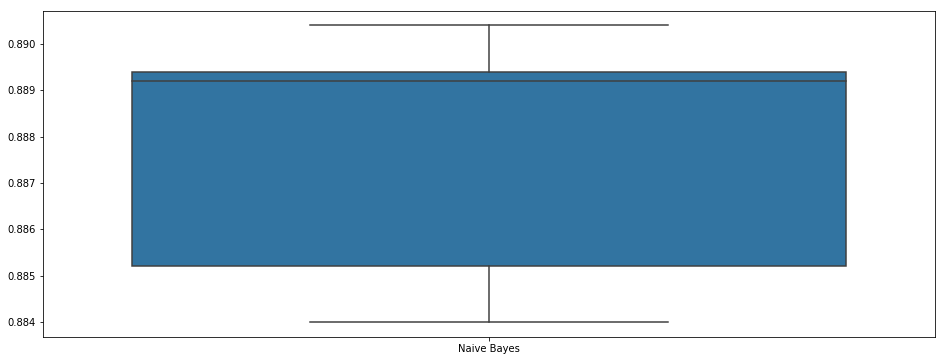

In [13]:
results ={'Names': Modelnames,'Results': outcome}
plt.figure(figsize=(16,6))
sns.boxplot(x='Names',y='Results',data=results);